# Municipality Analysis

In [2]:
#Cargando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('nutritive.csv')
df = df.drop(columns=['Unnamed: 0'])

C:\Users\OMAR\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.property_type.unique()

array(['Casa', 'Otro', 'Lote', 'Finca', 'Oficina', 'Apartamento',
       'Parqueadero', 'Local comercial', 'Depósito', nan], dtype=object)

## Sell and Rent Counting

In [5]:
df = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df.drop(columns=['id',"ad_type",'start_date', 'start_date','created_on','end_date',
                 'l1','l2', 'l3', 'l4','l6', 'l5', 
                 'rooms', 'price_period', 'surface_covered',
                 'operation_type','currency', 'title', 'description'], inplace=True)
df.shape

(613054, 7)

In [6]:
df_train = df.copy()
    
df_train = df_train[df_train['price']<df_train['price'].quantile(0.99)]
df_train = df_train[df_train['price'] > df_train['price'].quantile(0.1)]
df_train = df_train[df_train['surface_total'] > 0]
df_train = df_train[~np.isnan(df_train['price']) & df_train['price'] > 0]
df_train = df_train[df_train['surface_total'] > 0]

df_train['price'] = np.log(df_train['price'])

In [7]:
df

,lat,lon,bedrooms,bathrooms,surface_total,price,property_type
0,3.439000,-76.541000,12.0,6.0,202.0,5.000000e+08,Casa
2,3.566000,-76.550000,6.0,2.0,2500.0,1.400000e+08,Casa
3,4.736000,-75.896000,8.0,5.0,45000.0,8.000000e+08,Casa
4,3.661000,-76.576000,6.0,6.0,650.0,2.900000e+08,Casa
5,6.238877,-75.600494,7.0,4.0,290.0,0.000000e+00,Otro
...,...,...,...,...,...,...,...
937780,7.869000,-72.465000,5.0,7.0,1000.0,3.500000e+09,Casa
937781,7.873000,-72.464000,5.0,7.0,1262.0,1.500000e+09,Casa
937782,7.844000,-72.467000,5.0,7.0,344.0,1.100000e+09,Casa
937783,7.855000,-72.464000,7.0,7.0,500.0,8.500000e+08,Casa


## Machine Learning - Initial Model

In [8]:
X_df = df_train.drop('price', axis=1).copy()
Y_df = df_train['price'].copy()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(
    X_df, Y_df, test_size=0.2, random_state=5000)

In [11]:
# Para eliminar SettingWithCopyWarning

X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [12]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

### Power Transformer Labels (Box-Cox)

Normalize and reduce scale

In [13]:
box_cox = PowerTransformer(method='box-cox') # Box-Cox object instance
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Box-Cox, array 2 dimensions
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,property_type
20891,10.520541,-75.459302,NaN,2.0,-1.121563,Apartamento
721130,6.221462,-75.574342,NaN,NaN,2.368462,Lote
323198,4.109000,-73.632004,3.0,2.0,-0.977095,Apartamento
262458,1.214098,-77.284714,3.0,2.0,-0.332522,Apartamento
608336,10.434000,-75.533997,3.0,2.0,-1.121563,Apartamento


### Standard Scaler
El Standard Scaler sirve para centrar una distribución en 0 y que tenga desviación estándar unitaria.

 $$\mathbf{Z} = \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}}$$


In [14]:
# Categorical Class

print("Classes: ", X_train['property_type'].unique())
X_train.head()

Classes:  ['Apartamento' 'Lote' 'Casa' 'Otro' 'Finca' 'Local comercial' 'Depósito'
 'Oficina' 'Parqueadero']


,lat,lon,bedrooms,bathrooms,surface_total,property_type
20891,10.520541,-75.459302,NaN,2.0,-1.121563,Apartamento
721130,6.221462,-75.574342,NaN,NaN,2.368462,Lote
323198,4.109000,-73.632004,3.0,2.0,-0.977095,Apartamento
262458,1.214098,-77.284714,3.0,2.0,-0.332522,Apartamento
608336,10.434000,-75.533997,3.0,2.0,-1.121563,Apartamento


In [15]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

In [16]:
ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

C:\Users\OMAR\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Tratamiento de datos faltantes o NaN

In [17]:
from sklearn.impute import SimpleImputer

In [18]:
# Using Simple Imputer

si_bedrooms = SimpleImputer(strategy='mean')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

si_lat = SimpleImputer(strategy='mean')
si_lat.fit(X_train["lat"].values[:,None])
X_train["lat"] = si_lat.transform(X_train["lat"].values[:,None])

si_lon = SimpleImputer(strategy='mean')
si_lon.fit(X_train["lon"].values[:,None])
X_train["lon"] = si_lon.transform(X_train["lon"].values[:,None])

si_bath = SimpleImputer(strategy='mean')
si_bath.fit(X_train["bathrooms"].values[:,None])
X_train["bathrooms"] = si_bath.transform(X_train["bathrooms"].values[:,None])

In [19]:
#Otras transformaciones
cols2scale = ['bedrooms', 'bathrooms']
se_cols2scale = StandardScaler()
se_cols2scale.fit(X_train[cols2scale])
X_train[cols2scale] = se_cols2scale.transform(X_train[cols2scale])
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
20891,10.520541,-75.459302,-1.054210e-16,-0.644547,-1.121563,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
721130,6.221462,-75.574342,-1.054210e-16,0.000000,2.368462,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
323198,4.109000,-73.632004,-1.141283e-01,-0.644547,-0.977095,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262458,1.214098,-77.284714,-1.141283e-01,-0.644547,-0.332522,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608336,10.434000,-75.533997,-1.141283e-01,-0.644547,-1.121563,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_test['surface_total'] = box_cox.transform(X_test['surface_total'].values[:,None])


In [21]:
X_test['property_type'] = le_proper_type.transform(X_test['property_type'])

In [22]:
temp_test = ohe_proper_type.transform(X_test["property_type"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_op):
    X_test[col] = temp_test[:,idx]

X_test = X_test.drop("property_type", axis=1)

In [23]:
X_test['bedrooms'] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])
X_test['lat'] = si_lat.transform(X_test['lat'].values[:, None])
X_test['lon'] = si_lon.transform(X_test['lon'].values[:, None])
X_test['bathrooms'] = si_bath.transform(X_test['bathrooms'].values[:,None])

In [24]:
X_test[cols2scale] = se_cols2scale.transform(X_test[cols2scale])

In [25]:
assert (X_test.columns.values == X_train.columns.values).all()

In [26]:
X_test

,lat,lon,bedrooms,bathrooms,surface_total,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
600077,4.695000,-74.065000,-1.141283e-01,-0.644547,-0.622408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
474616,5.051308,-75.498328,8.354200e-01,-0.644547,-0.075920,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
891871,5.996558,-74.959800,8.354200e-01,4.355790,0.057304,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
718075,3.395000,-76.531000,3.606458e-01,1.498455,0.121964,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315157,3.371071,-76.509701,-1.054210e-16,-0.644547,-1.071152,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657254,6.244705,-75.601334,-1.141283e-01,-0.644547,-0.850546,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3450,4.644000,-74.074997,1.232588e-01,-0.644547,0.643914,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610777,4.684866,-74.125485,-1.054210e-16,2.212788,0.505177,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10576,5.996558,-74.959800,-1.141283e-01,0.069787,-0.257707,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Using Regression

In [27]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
extra_tree = ExtraTreeRegressor(splitter = "best" ,random_state=1000)
lin_reg = BaggingRegressor(extra_tree, random_state=1000, n_estimators=40)
lin_reg.fit(X_train, Y_train)

BaggingRegressor(base_estimator=ExtraTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   random_state=1000,
                                                   splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=40, n_jobs=None, oob_score=False,
                 random_state=1000, verbose=0,

In [28]:
Y_test_estimate = lin_reg.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
rmse = mean_squared_error(Y_test, Y_test_estimate)
print("Root Mean Square Error (RMSE)= {:.2f}".format(rmse))
mae = mean_absolute_error(Y_test, Y_test_estimate)
print("Mean Absolute Error (MAE)= {:.2f}".format(mae))
r2 = r2_score(Y_test, Y_test_estimate)
print("R^2 = {:.3f}".format(r2))

Root Mean Square Error (RMSE)= 0.13
Mean Absolute Error (MAE)= 0.22
R^2 = 0.816


In [29]:
#### cross validation of model

from sklearn.model_selection import  cross_val_score, KFold
kfold = KFold(n_splits=5)
results = cross_val_score(lin_reg, X_train, Y_train, cv=kfold)
print("Efectividad en la validacion : ", results,"\n Promedio de Efectividad predicciones : ", round(np.mean(results), 3))

Efectividad en la validacion :  [0.80001756 0.80016965 0.79337731 0.79759199 0.79441382] 
 Promedio de Efectividad predicciones :  0.797


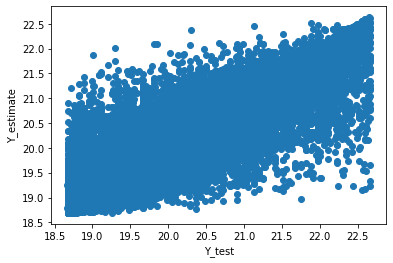

In [30]:
plt.scatter(Y_test, Y_test_estimate)
plt.xlabel("Y_test")
plt.ylabel("Y_estimate")
plt.show()